In [1]:
import pandas as pd
import numpy as np
import ot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
from pathlib import Path
from sklearn.utils import check_random_state
from scipy.spatial.distance import cdist
# User functions
from utils import BaseTransport, calc_parsimony

In [2]:
# Experiment hyperparamters
rng = np.random.RandomState(42)

In [3]:
# Setting so that the plots look normal even when using dark-reader
sn.set_style("whitegrid")
sn.set_context(context="paper", font_scale=2)
pal = sn.color_palette("Set1")

# Setting up specifics for plotting + saving
save_figures = True
add_legend = False
add_title = False
add_axis = False
save_parms = {'format': 'pdf','bbox_inches':'tight', 'pad_inches':0}
line_parms = {'linewidth':4, 'color':'k'}
if save_figures:  # saves all figures in a figure directory in the local directory
    figure_dir = Path('.') / 'figures' / 'adult-income-experiment'
    if not figure_dir.exists():
        figure_dir.mkdir(parents=True)

## Loading and Preprocessing the data


In [4]:
from data_utils import load_and_preprocess_nba_data
continuous_variables_indicies = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
# n_samples = 'balanced'
# n_samples = 1000
parameters_path = './Source_Target/experiment_parameters_YEAR<=2009_vs_YEAR>2009.csv'
X, Y, feature_names = load_and_preprocess_nba_data(parameters_path, rng, return_column_names=True)
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
print(X)
print(Y)
parameters = pd.read_csv(parameters_path)
split_on = parameters['split_feature'].values[0]
instance_1 = parameters['instance_1'].values[0]
instance_2 = parameters['instance_2'].values[0]


Splitting on Year with  YEAR <= 2009 and  YEAR > 2009 resulting source shape: (2472, 14), target shape: (2472, 14).
###############################
['Age', 'GamesPlayed', 'Wins', 'Losses', 'PointsScored', 'FG%', '3P%', 'FT%', 'TotalRebounds', 'Assists', 'Turnovers', 'Steals', 'Blocks', 'PersonalFouls']
###############################
######################## Source_Data_A Dropped ##########################
      Age  GamesPlayed  Wins  Losses  PointsScored   FG%   3P%   FT%  \
1058   30            5     2       3            39  42.9  58.3  87.5   
2179   24            6     2       4            48  39.5  14.3  76.5   
1709   25           22    13       9           539  41.3  24.7  81.3   
1550   27           20    10      10           160  43.3  20.0  84.2   
353    27            3     0       3             9  37.5   0.0  75.0   
...   ...          ...   ...     ...           ...   ...   ...   ...   
1638   27           10     4       6            31  54.5   0.0  70.0   
1095   37     

## Performing Clustering

In [5]:
def get_mixed_variable_desiderata(X_continuous, Y_continuous, Z, standardizer, continuous_variables_indicies,
                                  n_expectation=10, inter=None, rng=None):
    rng = check_random_state(rng)
    non_continuous_variables_indicies = np.delete(np.arange(X.shape[1]), continuous_variables_indicies)
    fids = np.zeros(n_expectation)
    pars = np.zeros(n_expectation)
    for loop_idx in range(n_expectation):
        # since Z is in a pseudo continuous space, we project it to a discrete space using the phase change graph defined within Z
        # since the Z[i, j_descrete] is probability of that point being positive
        Z_projected_discrete = Z.copy()
        uniform_vars = rng.uniform(size=(Z.shape[0], len(non_continuous_variables_indicies)))
        positive_probability = Z[:, non_continuous_variables_indicies]
        Z_projected_discrete[:, non_continuous_variables_indicies] = (uniform_vars <= positive_probability).astype(Z.dtype)
        Z_projected_continous = standardizer.transform(Z_projected_discrete)
        # Calculating fidelity
        M = cdist(Y_continuous, Z_projected_continous, 'sqeuclidean')
        a,b = ot.utils.unif(X.shape[0]), ot.utils.unif(Z.shape[0])
        fid = ot.emd2(a, b, M)
        # Calculating parsimony
        par = calc_parsimony(X_continuous, Z_projected_continous)
        # recording
        fids[loop_idx] = fid
        pars[loop_idx] = par
    fid, par = fids.mean(), pars.mean()
    if inter is not None:
        print(f'Fid: {fid:.3f}, Par: {par:.3f}, Inter: {inter}')
    return fid, par, inter

In [6]:
def mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_vars):
    non_continuous_vars = np.delete(np.arange(X_cluster.shape[1]), continuous_variables_indicies)
    X_cluster_pushed = X_cluster.copy()
    X_cluster_means = X_cluster.mean(axis=0)
    Z_cluster_means = Z_cluster.mean(axis=0)
    X_cluster_pushed[:, continuous_vars] += Z_cluster_means[continuous_vars] - X_cluster_means[continuous_vars]
    X_cluster_pushed[:, non_continuous_vars] = Z_cluster_means[non_continuous_vars]  # sets T(X_discrete) to Pr(Z_discrete = 1)
    return X_cluster_pushed

In [7]:
## Hyperparameters
max_clusters = 10

In [8]:
# Increasing the number of clusters to see the increase in fidelity and decrease in interpretability

cluster_histories = []

# fitting standardizer on our source domain
standardizer = standardizer.fit(X)

# Finding base desiderata values for T=id
X_continuous, Y_continuous = standardizer.transform(X), standardizer.transform(Y)
fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, X, standardizer, continuous_variables_indicies,
                                                n_expectation=1, inter=0, rng=rng)  # showing the base desiderata
fids = np.zeros(max_clusters+1)
fids[0] = fid
pars = np.zeros(max_clusters+1)
pars[0] = par
inters = np.zeros(max_clusters+1)
inters[0] = 0

################################################################################################################################################
T = BaseTransport(X, Y, fit=True)
Z = T.forward(X, Y)
Z_continuous = standardizer.transform(Z)

for n_clusters in range(1, max_clusters+1):
     # performs paired clustering in a continuous joint X,Z space
    cluster_labels = T._pair_clustering(X_continuous, Z=Z_continuous, n_clusters=n_clusters, rng=rng) 
    
    Z_clusters = np.zeros_like(Z)  # the final output of the cluster mean shift transport
    for cluster_idx in range(n_clusters):
        X_cluster = X[cluster_labels == cluster_idx]
        Z_cluster = Z[cluster_labels == cluster_idx]
        # A method similar for cluster mean shift transport, but with accounting for binary variables
        X_cluster_pushed = mixed_cluster_push_forward(X_cluster, Z_cluster, continuous_variables_indicies)
        Z_clusters[cluster_labels == cluster_idx] = X_cluster_pushed
        
    # getting desiderata information
    fid, par, inter = get_mixed_variable_desiderata(X_continuous, Y_continuous, Z_clusters, standardizer, 
                                                    continuous_variables_indicies, n_expectation=30,
                                                    inter=n_clusters, rng=rng)
    fids[n_clusters] = fid
    pars[n_clusters] = par
    inters[n_clusters] = n_clusters

    cluster_record = {
        'labels': cluster_labels.copy(),
        'Z_clusters': Z_clusters.copy(),
        'n_clusters': n_clusters
    }
    cluster_histories.append(cluster_record)

Fid: 2.404, Par: 0.000, Inter: 0
Fid: 2.245, Par: 391.438, Inter: 1
Fid: 2.219, Par: 456.751, Inter: 2
Fid: 2.202, Par: 516.329, Inter: 3
Fid: 2.180, Par: 588.488, Inter: 4
Fid: 2.165, Par: 622.547, Inter: 5
Fid: 2.159, Par: 648.206, Inter: 6
Fid: 2.149, Par: 660.156, Inter: 7
Fid: 2.131, Par: 730.957, Inter: 8
Fid: 2.113, Par: 771.996, Inter: 9
Fid: 2.047, Par: 954.440, Inter: 10


In [9]:
# changing fidelity to be % of shift explained
def calc_percent_explained(x):
    return 100*(max_fid - x) / max_fid
max_fid = fids[0]
percent_explained = np.apply_along_axis(calc_percent_explained, 0, fids)

Results with splitting on Year:


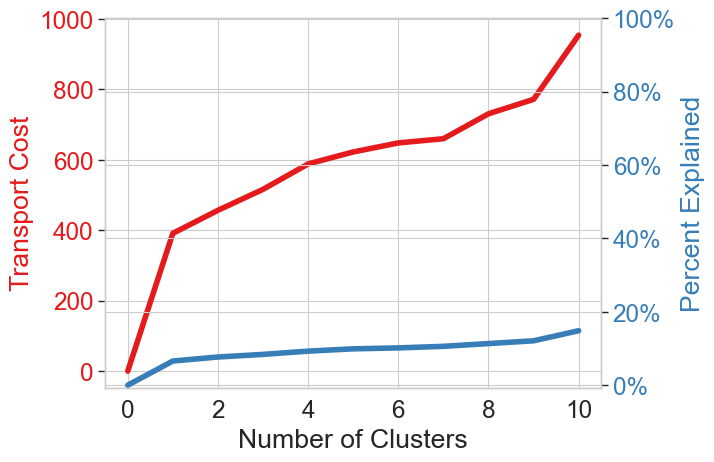

In [10]:
# Create Plot
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('Number of Clusters') 
ax1.set_ylabel('Transport Cost', color = pal[0]) 
ax1.plot(np.arange(max_clusters+1), pars, color = pal[0],
         **{k:v for (k,v) in line_parms.items() if k != 'color'})  
ax1.tick_params(axis ='y', labelcolor = pal[0]) 
# Adding Twin Axes
ax2 = ax1.twinx() 
ax2.set_ylabel('Percent Explained', color = pal[1]) 
ax2.plot(np.arange(max_clusters+1), percent_explained, color = pal[1],
         **{k:v for (k,v) in line_parms.items() if k != 'color'}) 
ax2.tick_params(axis ='y', labelcolor = pal[1]) 
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_ylim(None, 100)


print(f'Results with splitting on {split_on}:')
if save_figures: plt.savefig(
    figure_dir / f'logitics_data_on{split_on}--clustering-results.{save_parms["format"]}',
    **save_parms
    )
plt.show()

In [51]:
nba_dict = {}
for record_idx in range(max_clusters):
    cluster_record = cluster_histories[record_idx]
    Z_clusters = cluster_record['Z_clusters']
    labels = cluster_record['labels']
    n_clusters = cluster_record['n_clusters']
    tgt = f'{instance_2}'
    src = f'{instance_1}'
    nba_dict[record_idx] = {}

    with np.printoptions(precision=3, suppress=True):
        for cluster_idx in range(n_clusters):
            print(f'\tCluster: {cluster_idx}')
            print(f'\t\t         Names={[name[:3] for name in feature_names]}')
            print(f'\t\t   {src}_mean={X[cluster_idx==labels].mean(axis=0)}')
            print(f'\t\tT({tgt})_mean={Z_clusters[cluster_idx==labels].mean(axis=0)}')
            nba_dict[record_idx][cluster_idx] = {}

            nba_dict[record_idx][cluster_idx]['src_means'] = X[cluster_idx==labels].mean(axis=0)
            nba_dict[record_idx][cluster_idx]['trg_means'] = Z_clusters[cluster_idx==labels].mean(axis=0)

        print()

      

	Cluster: 0
		         Names=['Age', 'Gam', 'Win', 'Los', 'Poi', 'FG%', '3P%', 'FT%', 'Tot', 'Ass', 'Tur', 'Ste', 'Blo', 'Per']
		    YEAR <= 2009_mean=[28.398  8.153  4.07   4.082 76.931 40.398 19.062 62.431 33.643 15.969
 10.821  5.872  3.98  19.286]
		T( YEAR > 2009)_mean=[27.542  8.511  4.258  4.254 86.047 41.881 25.034 62.115 35.466 17.886
 10.443  5.922  4.004 17.557]

	Cluster: 0
		         Names=['Age', 'Gam', 'Win', 'Los', 'Poi', 'FG%', '3P%', 'FT%', 'Tot', 'Ass', 'Tur', 'Ste', 'Blo', 'Per']
		    YEAR <= 2009_mean=[ 28.739  15.998   9.566   6.432 204.715  44.963  25.855  75.151  85.816
  42.848  27.678  14.998  10.665  44.648]
		T( YEAR > 2009)_mean=[ 27.983  16.146   9.652   6.494 223.337  46.461  29.392  77.577  88.511
  48.296  26.848  14.814  10.427  40.136]
	Cluster: 1
		         Names=['Age', 'Gam', 'Win', 'Los', 'Poi', 'FG%', '3P%', 'FT%', 'Tot', 'Ass', 'Tur', 'Ste', 'Blo', 'Per']
		    YEAR <= 2009_mean=[28.29   5.654  2.321  3.334 36.244 38.944 16.9   58.381 17.031  

In [63]:
# Assuming max_clusters and nba_dict are predefined elsewhere in your script
vis_clusters = max_clusters
total_distance = []
attributes_list_names = ['Age', 'Gam', 'Win', 'Los', 'Poi', 'FG%', '3P%', 'FT%', 'Tot', 'Ass', 'Tur', 'Ste', 'Blo', 'Per']

# Initialize differences for each cluster
for cluster_idx in range(0, vis_clusters):
    nba_dict[vis_clusters-1][cluster_idx]["differences"] = {}

# Calculate distances for all clusters and attributes
for cluster_idx in range(0, vis_clusters):
    for i, attribute in enumerate(attributes_list_names):
        val_0 = nba_dict[vis_clusters-1][cluster_idx]['src_means'][i]
        val_1 = nba_dict[vis_clusters-1][cluster_idx]['trg_means'][i]
        nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] = (val_1 - val_0)

    # Calculate the total distance for the cluster
    total_distance.append(np.sqrt(sum((nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute]) ** 2 for attribute in attributes_list_names)))

# Create a DataFrame with the calculated differences
distances = pd.DataFrame({
    'Cluster': range(vis_clusters),
    'Total_distance': total_distance
})

# Add each attribute's differences as a separate column
for attribute in attributes_list_names:
    distances[attribute] = [nba_dict[vis_clusters-1][cluster_idx]["differences"][attribute] for cluster_idx in range(vis_clusters)]

# Sort distances by total distance
distances = distances.sort_values(by='Total_distance')

display(distances)

output_path = f'./NBA_results/distance_from_{instance_1}.csv'
distances.to_csv(output_path, index=False)


,Cluster,Total_distance,Age,Gam,Win,Los,Poi,FG%,3P%,FT%,Tot,Ass,Tur,Ste,Blo,Per
9,9,2.503362,-1.786047,-0.213953,-0.134884,-0.079070,0.218605,0.991628,0.871628,-0.798605,0.260465,-0.037209,-0.158140,-0.041860,-0.041860,-0.693023
5,5,9.465829,-0.478261,0.581028,0.349802,0.231225,7.691700,3.483004,3.789130,-0.149209,1.650198,0.243083,-0.476285,-0.019763,0.363636,-0.211462
0,0,10.779700,-0.465116,0.887043,0.508306,0.378738,8.099668,1.347841,5.176744,-1.423588,3.631229,2.063123,0.534884,0.322259,0.019934,-0.847176
1,1,12.620162,-1.466418,0.011194,0.115672,-0.104478,0.376866,1.208209,10.858955,-5.555597,-1.115672,-0.074627,-0.664179,-0.339552,-0.201493,-2.205224
7,7,13.308974,-0.297927,0.515544,0.354922,0.160622,10.976684,1.453627,6.384197,0.038860,2.196891,1.168394,-1.158031,0.012953,0.414508,-2.357513
4,4,14.471412,-1.089888,0.421348,-0.025281,0.446629,7.115169,-0.800281,12.248315,0.272753,2.019663,1.457865,0.300562,0.443820,0.053371,-0.002809
6,6,18.622724,-1.438356,0.547945,0.280822,0.267123,14.417808,2.038356,5.806849,2.458904,5.404110,4.979452,-2.157534,-0.493151,0.136986,-5.794521
3,3,20.119275,-1.102151,0.000000,-0.129032,0.129032,18.338710,1.693011,-0.608602,1.529032,5.010753,4.177419,-1.500000,-0.715054,1.327957,-3.817204
2,2,42.598149,-0.164179,-1.014925,-0.477612,-0.537313,38.880597,1.511940,2.880597,3.150746,11.373134,9.686567,4.417910,2.611940,2.597015,-4.955224
8,8,52.615901,-0.731707,0.195122,0.439024,-0.243902,28.463415,-0.704878,10.680488,10.165854,-29.951220,21.902439,-0.097561,0.097561,-16.731707,-9.097561


In [12]:
# ergonomic blank space : ) 






























































